<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/main/src/tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [2]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [13]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

filenames = tf.io.gfile.glob(audio_dir + '*')
filenames = tf.random.shuffle(filenames, seed=42)

print('Total audios:', len(filenames))

Total audios: 21024


In [14]:
import os

test_file = filenames[0]

def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  return label
get_label(test_file), test_file

(<tf.Tensor: shape=(), dtype=string, numpy=b'laughter'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m0520_0_laughter.wav'>)

In [15]:
def get_signal(file_path):
  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]
  return tf.squeeze(signal, axis=-1)

get_signal(test_file), test_file

(<tf.Tensor: shape=(116053,), dtype=float32, numpy=
 array([1.8310547e-04, 9.1552734e-05, 1.5258789e-04, ..., 7.3242188e-04,
        0.0000000e+00, 8.2397461e-04], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m0520_0_laughter.wav'>)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

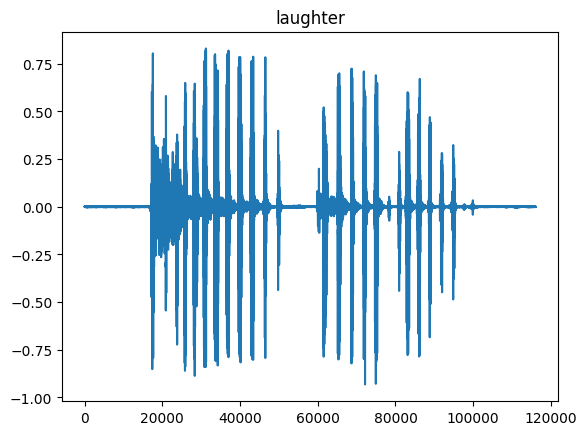

In [17]:
import matplotlib.pyplot as plt
for elem in ds.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(label.numpy().decode('utf-8'))

In [64]:
if not ds.element_spec[0].shape[0] == 64_000:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  filenames = tf.constant([file for file in filenames if get_signal(file).shape[0] >= min_len])

  ds_files = tf.data.Dataset.from_tensor_slices(filenames)
  ds = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

  ds = ds.padded_batch(padded_shapes=[min_len])


ds.element_spec[0].shape[0]



In [22]:
from functools import partial
def fix_len(x):
  return x[0], x[1]

ds.map(lambda x: (x[0], x[1]))

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 1 positional argument but 2 were given


In [ ]:
ds_signals =  tf.data.Dataset.from_tensor_slices((signals, labels))
for elem in ds_signals.take(1):
    print(elem)

In [ ]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [ ]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [ ]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(64, activation='relu', input_shape=(64000,)),  # Capa de entrada con 64 neuronas
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

In [ ]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(1024, activation='relu', input_shape=(64000,)),  # Capa de entrada con 1024 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

In [ ]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)